In [1]:
import tensorflow as tf
import librosa
from models.gan import * 
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load style and content

In [2]:
CONTENT_FILENAME = "inputs/original_inputs/imperial.mp3"
STYLE_FILENAME = "inputs/original_inputs/usa.mp3"

In [3]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [4]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [5]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

### Visualize spectrograms for content and style tracks

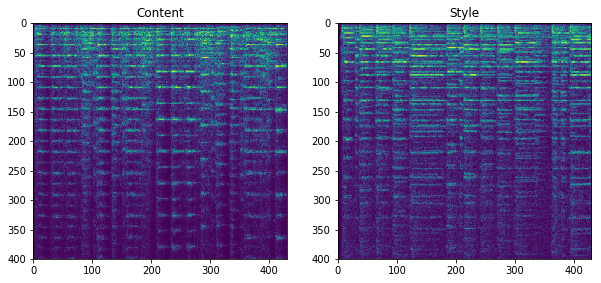

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

### Compute content and style feats

In [7]:
input_batch_placeholder = tf.placeholder(tf.float32, shape=(2, N_SAMPLES, N_CHANNELS), name="input_batch")
layer_features, G_sample, _, _, _, _, run_training_step = \
            setup_gan(input_batch_placeholder, tf.constant(np.array([N_SAMPLES, N_SAMPLES])))
input_batch = np.array([a_style.T, a_content.T])
feed_dict={input_batch_placeholder:input_batch}

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(250):
    d_loss, g_loss = run_training_step(sess, feed_dict)
    print("iteration {}, d_loss: {}, g_loss: {}".format(i, d_loss, g_loss))

# TODO would be interesting to try other layers for the style / content features
# Especially interesting to try the fixed length layer (output of the encoder) for content
content_features = sess.run(layer_features[3], feed_dict={input_batch_placeholder:input_batch})[1, :, :]
style_features = sess.run(layer_features[1], feed_dict={input_batch_placeholder:input_batch})[0, :, :]

features = style_features # np.reshape(style_features, (-1, N_FILTERS))
style_gram = np.matmul(features.T, features) / N_SAMPLES

[2, 420, 256]
[2, 430, 256]
[2, 430, 1025]
iteration 0, d_loss: -11.6180143356, g_loss: 3.79341411591
iteration 1, d_loss: -19.1791706085, g_loss: 6.86395025253
iteration 2, d_loss: -27.9897918701, g_loss: 5.78773546219
iteration 3, d_loss: -49.6824493408, g_loss: -0.342118263245
iteration 4, d_loss: -47.8047561646, g_loss: 30.7528533936
iteration 5, d_loss: -13.3572483063, g_loss: 24.1466064453
iteration 6, d_loss: -18.4243202209, g_loss: 27.5009269714
iteration 7, d_loss: -66.1404953003, g_loss: 32.1348419189
iteration 8, d_loss: -79.9349365234, g_loss: 33.1180763245
iteration 9, d_loss: -37.0910758972, g_loss: 35.8525390625
iteration 10, d_loss: -41.6627960205, g_loss: 41.3977508545
iteration 11, d_loss: -50.7780723572, g_loss: 48.4686508179
iteration 12, d_loss: -56.950050354, g_loss: 52.8113975525
iteration 13, d_loss: -62.4608688354, g_loss: 55.1660766602
iteration 14, d_loss: -45.224319458, g_loss: 58.6298446655
iteration 15, d_loss: -55.4818115234, g_loss: 59.9018783569
iterati

In [8]:
print(sess.run([tf.shape(G_sample)]))

[array([   2,  430, 1025], dtype=int32)]


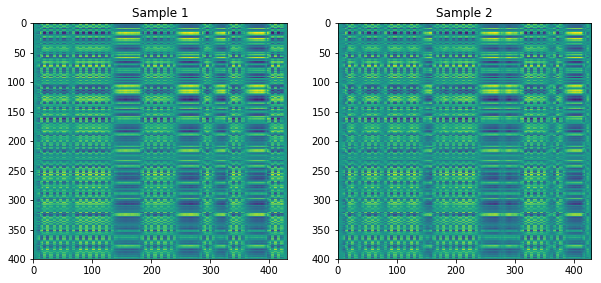

In [9]:
g_sample = sess.run(G_sample, feed_dict={input_batch_placeholder:input_batch})
g_sample = np.transpose(g_sample, (0, 2, 1))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Sample 1')
plt.imshow(g_sample[1, :400,:])
plt.subplot(1, 2, 2)
plt.title('Sample 2')
plt.imshow(g_sample[0, :400,:])
plt.show()

In [10]:
sample = np.zeros_like(a_content)
sample[:N_CHANNELS,:] = np.exp(g_sample[1]) - 1 # np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(sample.shape) - np.pi
for i in range(500):
    S = sample * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/gan_sample.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)
print OUTPUT_FILENAME
display(Audio(OUTPUT_FILENAME))

outputs/content_reconstruction.wav


### Optimize

In [33]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 300

result = None

# Build graph with variable input
#  x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
x = tf.Variable(np.random.randn(1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="style_transfer_x")
# x = tf.Variable(np.expand_dims(a_content.T.astype(np.float32), 0), name="x")

with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    _, layer_features = discriminator(x, tf.constant(np.array([N_SAMPLES])), is_training=False)

x_content_features = layer_features[3]
x_style_features = layer_features[1]

x_style_features = tf.squeeze(x_style_features, axis=[0])
x_style_gram = tf.matmul(tf.transpose(x_style_features), x_style_features)  / N_SAMPLES

content_loss = ALPHA * 2 * tf.nn.l2_loss(
        x_content_features - content_features)
style_loss = 2 * tf.nn.l2_loss(x_style_gram - style_gram)

 # Overall loss
loss = content_loss + style_loss

# TODO: Try different optimizers here - Adam is usually the best, so why not use Adam
#opt = tf.contrib.opt.ScipyOptimizerInterface(
#      loss, var_list=[x], method='L-BFGS-B', options={'maxiter': 300})
decay = tf.placeholder(shape=(), dtype=tf.float32, name="decay")
style_transfer_optimizer_op = tf.train.AdamOptimizer(learning_rate=learning_rate*decay).minimize(loss)

# Optimization
sess.run(tf.global_variables_initializer())

print('Started optimization.')
#opt.minimize(sess)
for i in range(1000):
    step_decay = 1.0
    if i > 300:
        step_decay = 0.5
    if i > 700:
        step_decay = 0.1
    if i > 925:
        step_decay = 0.05
    st_step_loss, _ = sess.run([loss, style_transfer_optimizer_op], feed_dict={decay : step_decay})
    print("Loss: {}, decay: {}".format(st_step_loss, step_decay))

print 'Final loss:', loss.eval(session=sess)
result = sess.run(x)

Started optimization.
Loss: 6405296640.0, decay: 1.0
Loss: 6405297152.0, decay: 1.0
Loss: 6405293568.0, decay: 1.0
Loss: 6405280768.0, decay: 1.0
Loss: 6405233152.0, decay: 1.0
Loss: 6405087232.0, decay: 1.0
Loss: 6404701184.0, decay: 1.0
Loss: 6403764736.0, decay: 1.0
Loss: 6401655296.0, decay: 1.0
Loss: 6397181440.0, decay: 1.0
Loss: 6388187136.0, decay: 1.0
Loss: 6370965504.0, decay: 1.0
Loss: 6339427328.0, decay: 1.0
Loss: 6283992576.0, decay: 1.0
Loss: 6190203904.0, decay: 1.0
Loss: 6037228544.0, decay: 1.0
Loss: 5796853760.0, decay: 1.0
Loss: 5434104832.0, decay: 1.0
Loss: 4912384000.0, decay: 1.0
Loss: 4209994496.0, decay: 1.0
Loss: 3357576192.0, decay: 1.0
Loss: 2513480448.0, decay: 1.0
Loss: 2090114432.0, decay: 1.0
Loss: 2480555008.0, decay: 1.0
Loss: 2400857344.0, decay: 1.0
Loss: 1727576576.0, decay: 1.0
Loss: 1136207616.0, decay: 1.0
Loss: 890136576.0, decay: 1.0
Loss: 871865600.0, decay: 1.0
Loss: 893029760.0, decay: 1.0
Loss: 851549632.0, decay: 1.0
Loss: 734259008.0, de

### Invert spectrogram and save the result

In [32]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0].T) - 1 # np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)
print OUTPUT_FILENAME
display(Audio(OUTPUT_FILENAME))

KeyboardInterrupt: 

### Visualize spectrograms

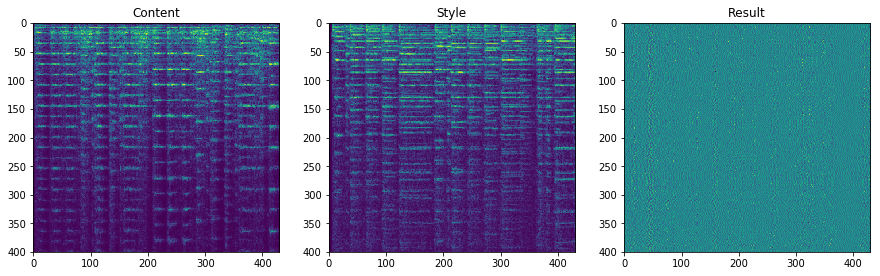

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()